In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [2]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [3]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [6]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),

    "y": Y_obs['Count_120'],
    "P": X_obs.shape[1],

    "nyears": 13,
    "nstations": 45,
    "nmonths": 7,

    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,

    "X": X_obs,
    "X_miss": X_miss,

    "phi": phi,
    "distances": distances,

    "month": months_obs,
    "month_miss": months_miss
}

In [7]:
Models_df = pd.DataFrame(columns = ['WAIC', 'LOO', 'MSE', 'MAE', 'MAD', 'inside CI', 'MSE test', 'MAE test', 'MAD test', 'inside CI test'])

In [8]:
bin_logit = FetchModel('bin_logit').compile()

In [9]:
bin_logit_120 = bin_logit.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_logit_120 = az.from_cmdstanpy(bin_logit_120)

01:15:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:50:51 - cmdstanpy - INFO - CmdStan done processing.


01:50:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit.stan', line 52, column 2 to column 63)
Consider re-running with show_console=True if the above output is unclear!


In [10]:
post_pred = PostPred(posterior_bin_logit_120, Y['Count_120'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

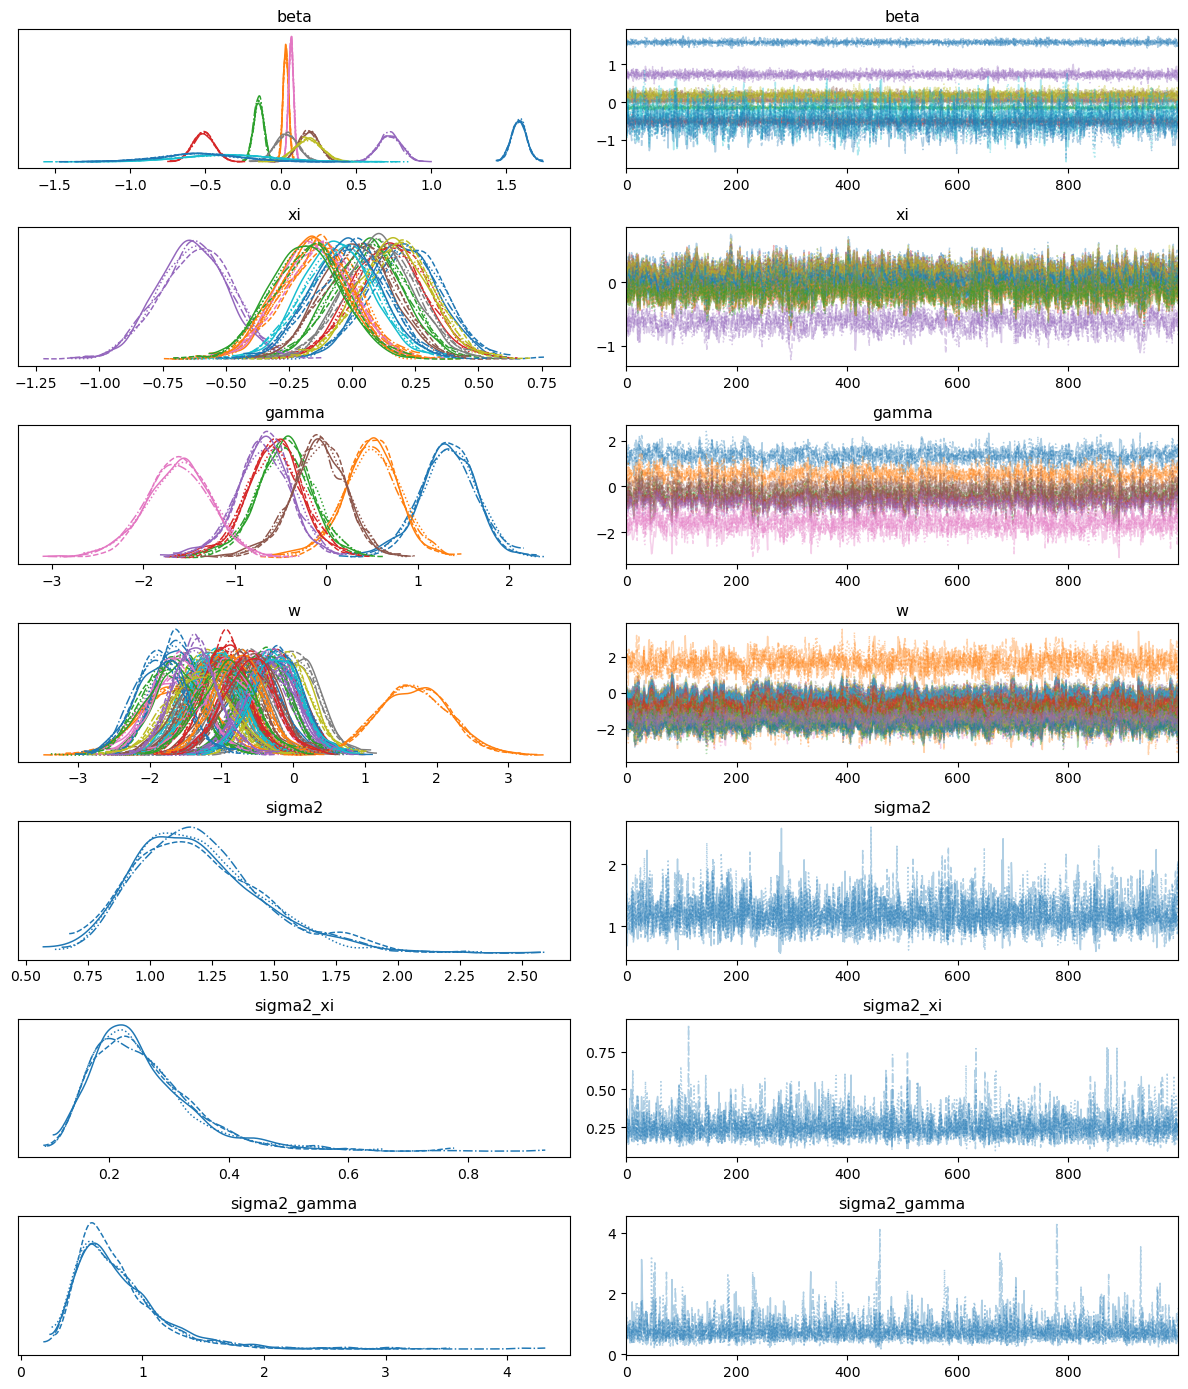

In [11]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma'])
plt.tight_layout()
plt.show()

In [12]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6634.09    97.36
p_waic      155.93        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6634.49    97.37
p_loo      156.33        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2688  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [13]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [14]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 469

The total number of outliers in the test set is: 164

The MSE is: 10.416666666666666

The MAE is: 2.3033854166666665

The MAD is: 2.0

The MSE in the test set is: 11.82638888888889

The MAE in the test set is: 2.4444444444444446

The MAD in the test set is: 2.0

The percentage of observations inside the CI is: 0.8778645833333334

The percentage of observations inside the CI of the test is: 0.8576388888888888



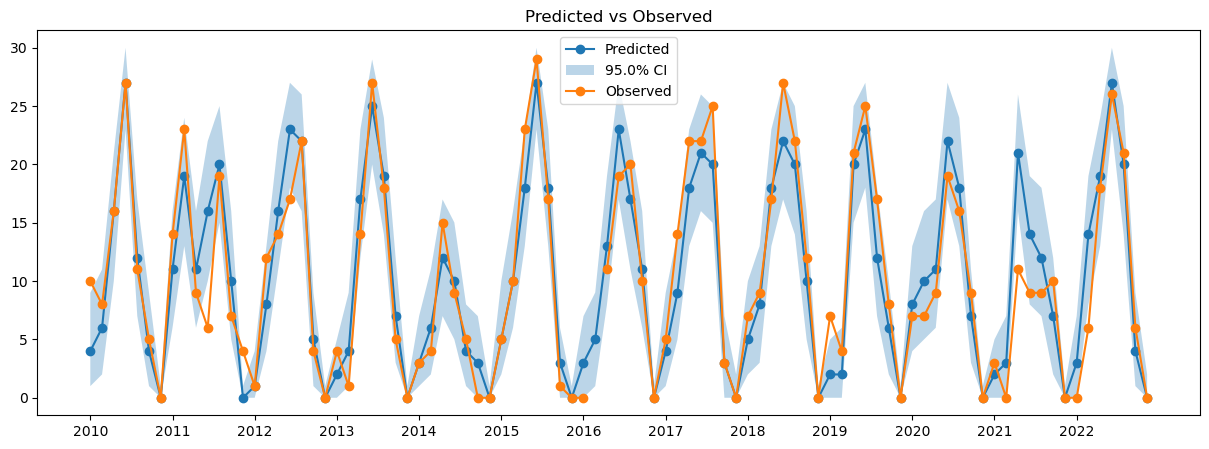

In [15]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2023))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [16]:
Models_df.loc['logit',:] = [waic, loo, mse, mae, mad, percentage_inside, mse_test, mae_test, mad_test, percentage_inside_CI_test]
print(Models_df)

              WAIC         LOO        MSE       MAE  MAD inside CI   MSE test  \
logit -6634.094016 -6634.49357  10.416667  2.303385  2.0  0.877865  11.826389   

       MAE test MAD test inside CI test  
logit  2.444444      2.0       0.857639  


In [17]:
bin_probit = FetchModel('bin_probit').compile()

In [18]:
bin_probit_120 = bin_probit.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_probit_120 = az.from_cmdstanpy(bin_probit_120)

01:54:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:58 - cmdstanpy - INFO - CmdStan done processing.
02:24:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit.stan', line 52, column 2 to column 63)
Consider re-running with show_console=True if the above output is unclear!


In [19]:
post_pred = PostPred(posterior_bin_probit_120, Y['Count_120'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

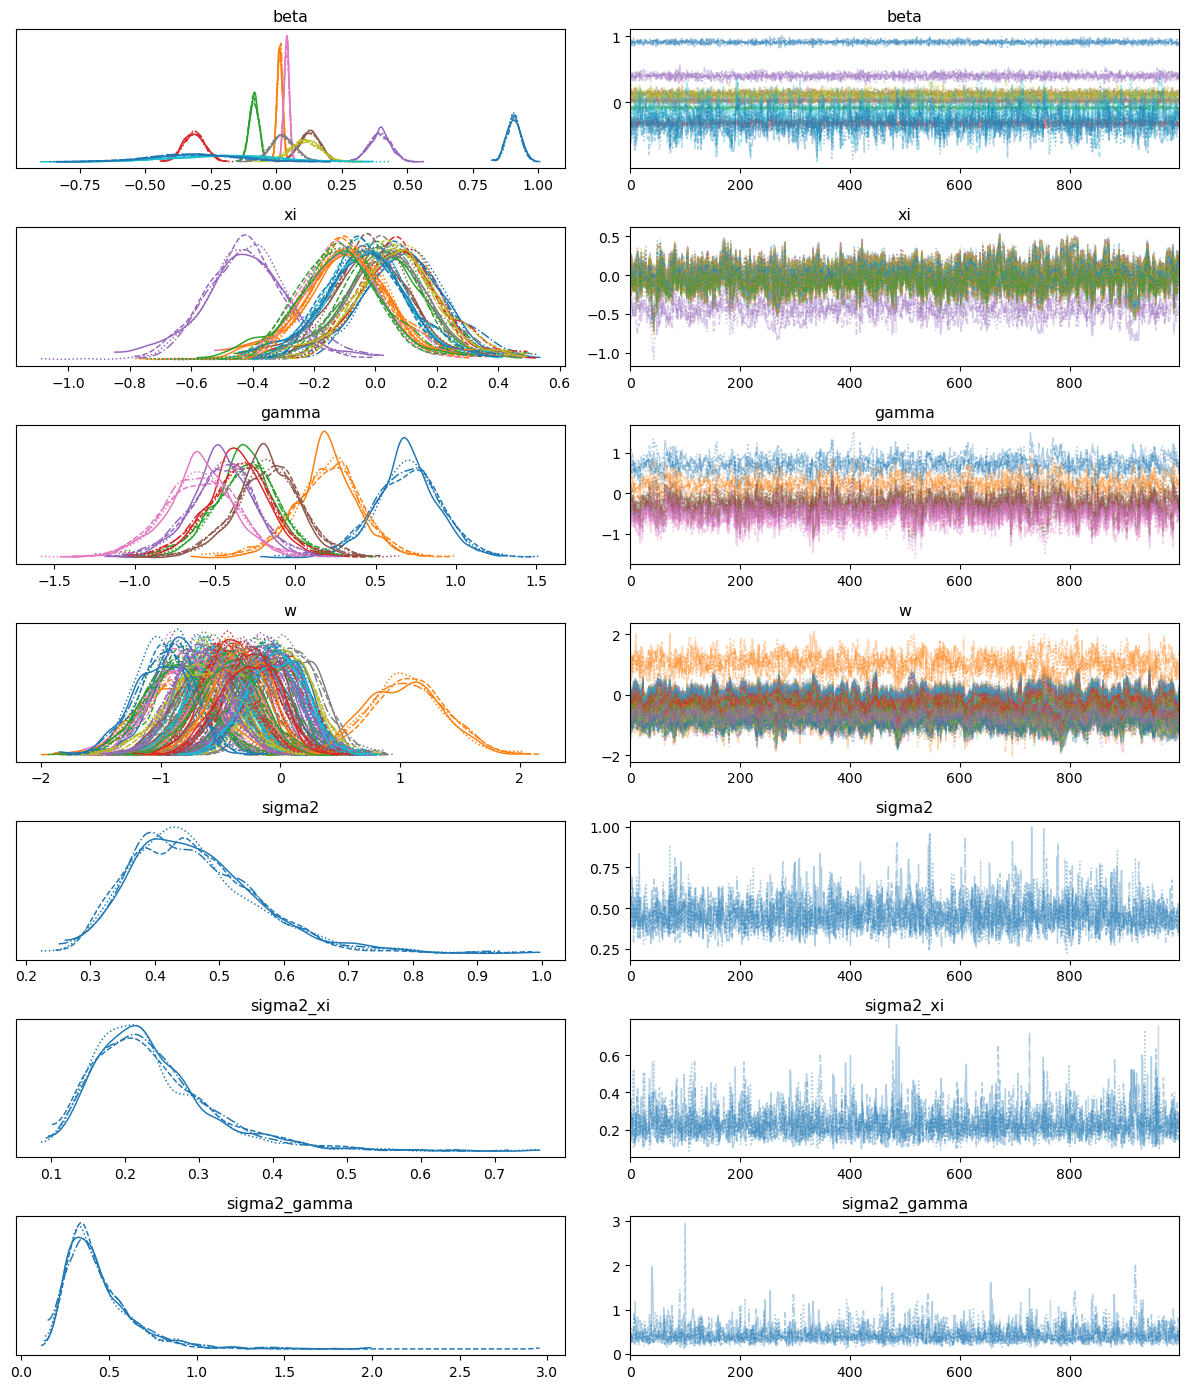

In [20]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma'])
plt.tight_layout()
plt.show()

In [21]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6669.21    99.02
p_waic      160.93        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6669.58    99.03
p_loo      161.30        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2688  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [22]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [23]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 482

The total number of outliers in the test set is: 168

The MSE is: 10.588411458333333

The MAE is: 2.3307291666666665

The MAD is: 2.0

The MSE in the test set is: 12.041666666666666

The MAE in the test set is: 2.470486111111111

The MAD in the test set is: 2.0

The percentage of observations inside the CI is: 0.8744791666666667

The percentage of observations inside the CI of the test is: 0.8541666666666666



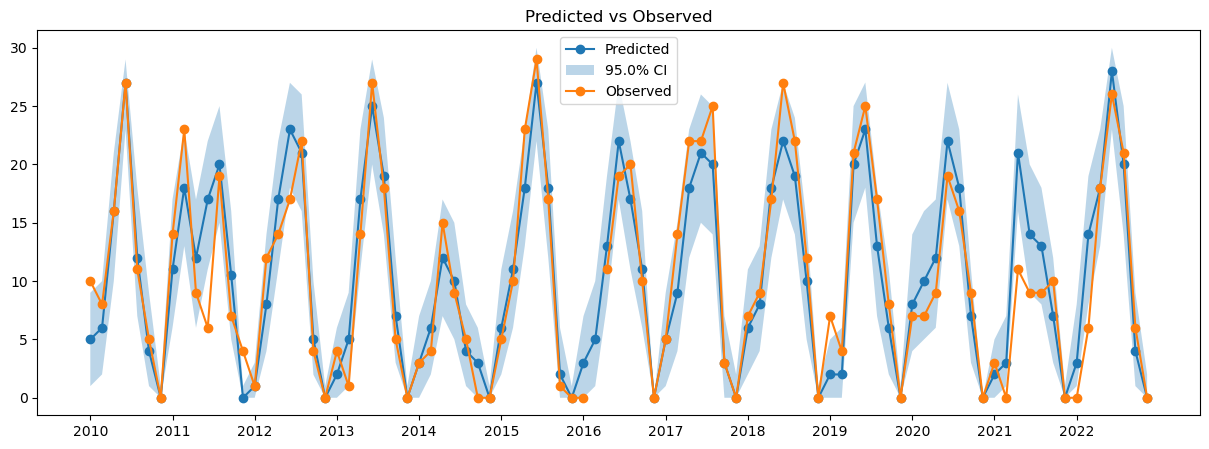

In [24]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2023))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [25]:
Models_df.loc['probit', :] = [waic, loo, mse, mae, mad, percentage_inside, mse_test, mae_test, mad_test, percentage_inside_CI_test]
print(Models_df)

               WAIC          LOO        MSE       MAE  MAD inside CI  \
logit  -6634.094016  -6634.49357  10.416667  2.303385  2.0  0.877865   
probit -6669.207368 -6669.575221  10.588411  2.330729  2.0  0.874479   

         MSE test  MAE test MAD test inside CI test  
logit   11.826389  2.444444      2.0       0.857639  
probit  12.041667  2.470486      2.0       0.854167  


In [26]:
bin_logit_var = FetchModel('bin_logit_var').compile()

In [27]:
bin_logit_var_120 = bin_logit_var.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_logit_var_120 = az.from_cmdstanpy(bin_logit_var_120)

02:26:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:31 - cmdstanpy - INFO - CmdStan done processing.
02:35:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 52, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 52, column 2 to column 63)
Consider re-running with show_

In [28]:
post_pred = PostPred(posterior_bin_logit_var_120, Y['Count_120'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

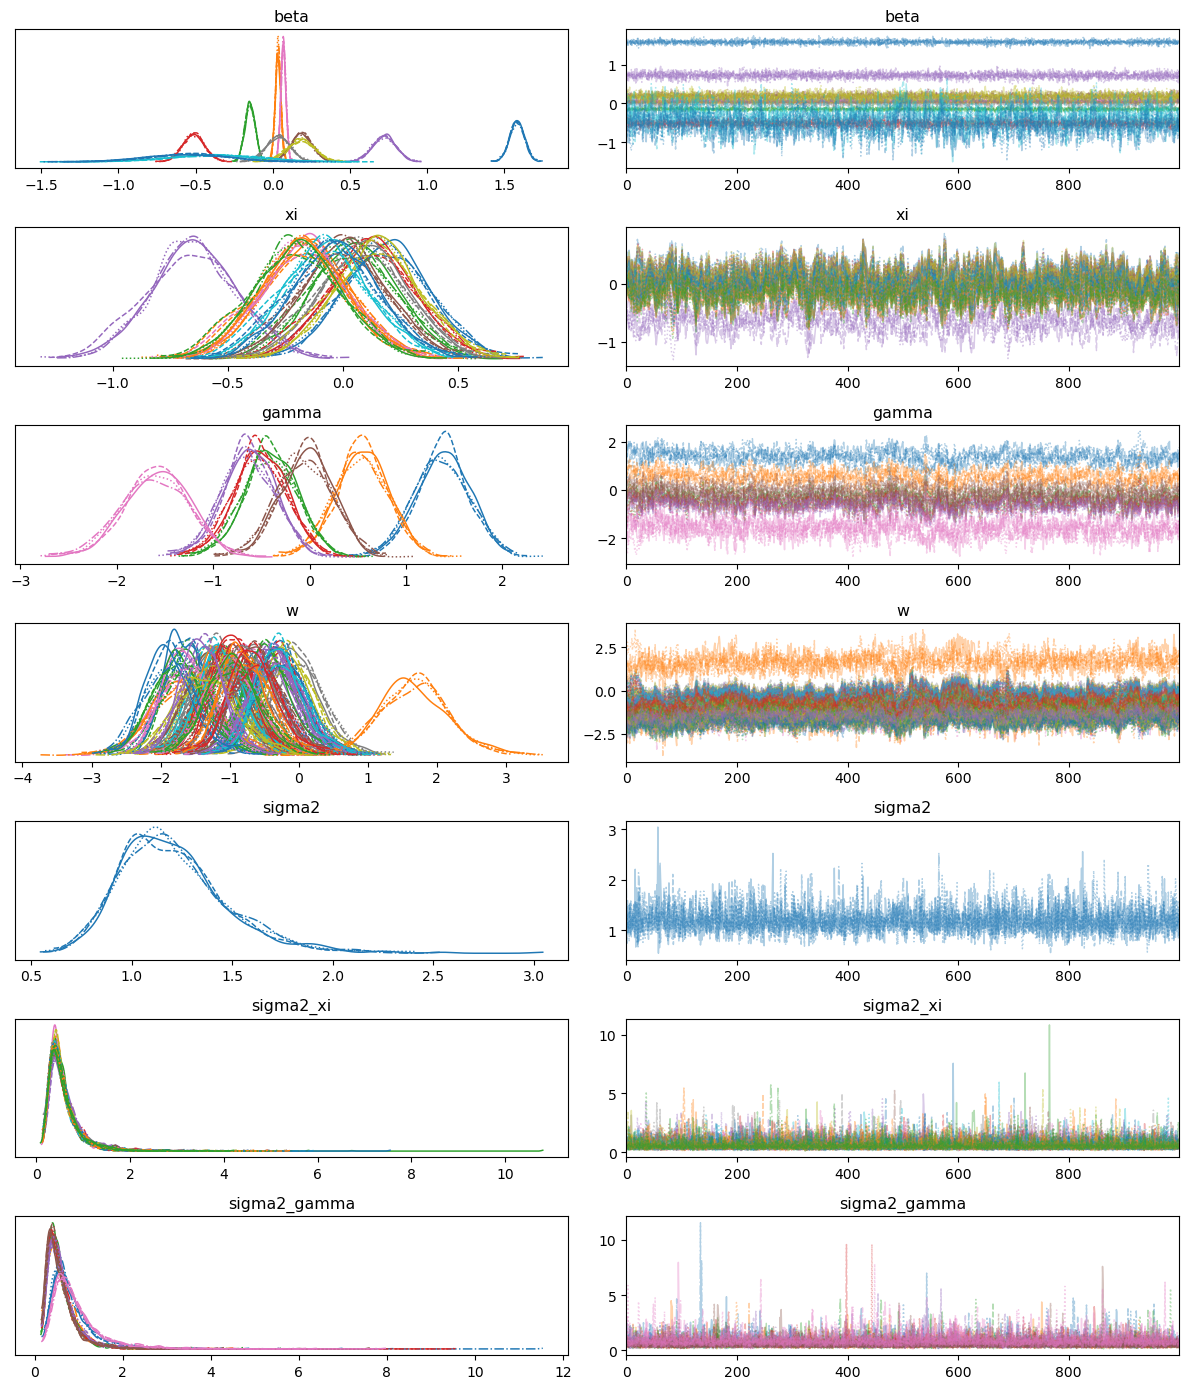

In [29]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma'])
plt.tight_layout()
plt.show()

In [30]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6633.34    97.42
p_waic      154.96        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6633.63    97.42
p_loo      155.26        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2688  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [31]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [32]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 477

The total number of outliers in the test set is: 166

The MSE is: 10.4484375

The MAE is: 2.3036458333333334

The MAD is: 2.0

The MSE in the test set is: 11.9140625

The MAE in the test set is: 2.4539930555555554

The MAD in the test set is: 2.0

The percentage of observations inside the CI is: 0.87578125

The percentage of observations inside the CI of the test is: 0.8559027777777778



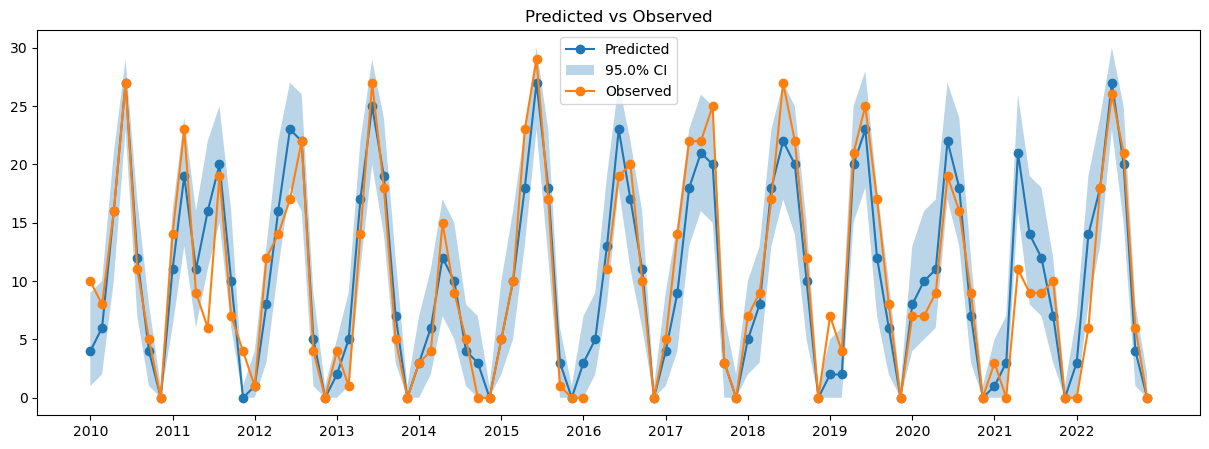

In [33]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2023))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [34]:
Models_df.loc['logit var', :] = [waic, loo, mse, mae, mad, percentage_inside, mse_test, mae_test, mad_test, percentage_inside_CI_test]
print(Models_df)

                  WAIC          LOO        MSE       MAE  MAD inside CI  \
logit     -6634.094016  -6634.49357  10.416667  2.303385  2.0  0.877865   
probit    -6669.207368 -6669.575221  10.588411  2.330729  2.0  0.874479   
logit var -6633.335465 -6633.629074  10.448438  2.303646  2.0  0.875781   

            MSE test  MAE test MAD test inside CI test  
logit      11.826389  2.444444      2.0       0.857639  
probit     12.041667  2.470486      2.0       0.854167  
logit var  11.914062  2.453993      2.0       0.855903  


In [35]:
bin_probit_var = FetchModel('bin_probit_var').compile()

In [36]:
bin_probit_var_120 = bin_probit_var.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_probit_var_120 = az.from_cmdstanpy(bin_probit_var_120)

02:36:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:07 - cmdstanpy - INFO - CmdStan done processing.
02:48:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit_var.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit_var.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit_var.stan', line 52, column 2 to column 63)
Consider re-running with show_console=True if the above output is unclear!


In [37]:
post_pred = PostPred(posterior_bin_probit_var_120, Y['Count_120'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

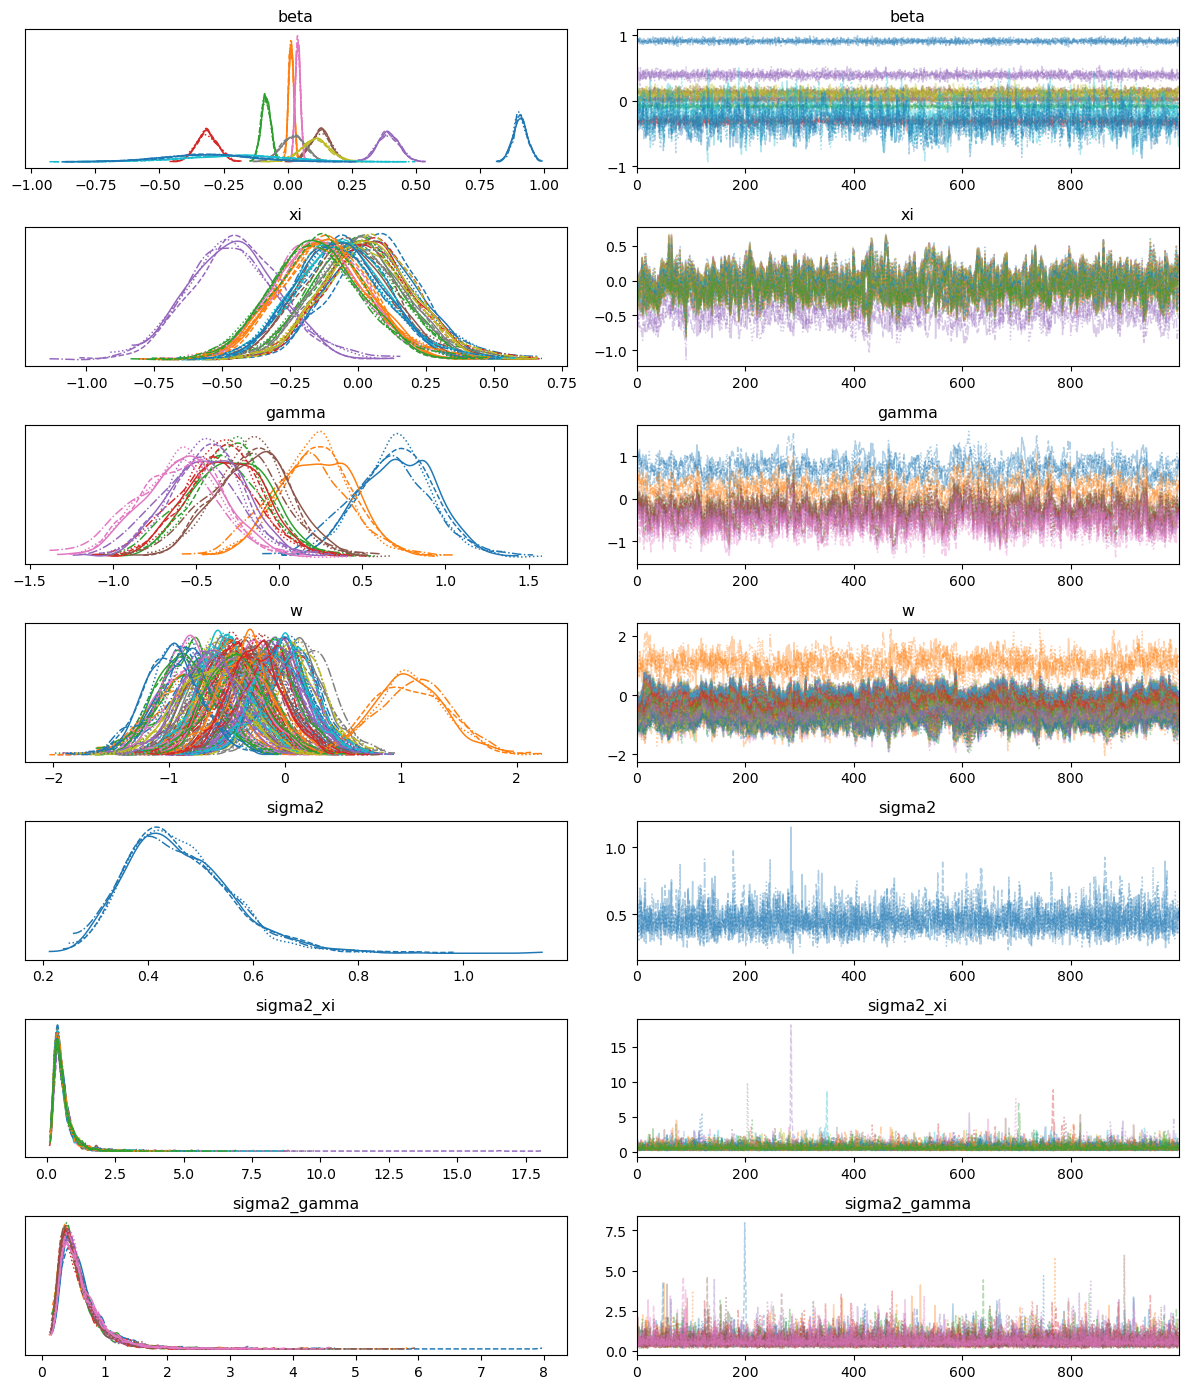

In [38]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma'])
plt.tight_layout()
plt.show()

In [39]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6669.07    99.02
p_waic      160.80        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6669.45    99.03
p_loo      161.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2687  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [40]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [41]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 492

The total number of outliers in the test set is: 176

The MSE is: 10.581705729166666

The MAE is: 2.325390625

The MAD is: 2.0

The MSE in the test set is: 12.057725694444445

The MAE in the test set is: 2.46875

The MAD in the test set is: 2.0

The percentage of observations inside the CI is: 0.871875

The percentage of observations inside the CI of the test is: 0.8472222222222222



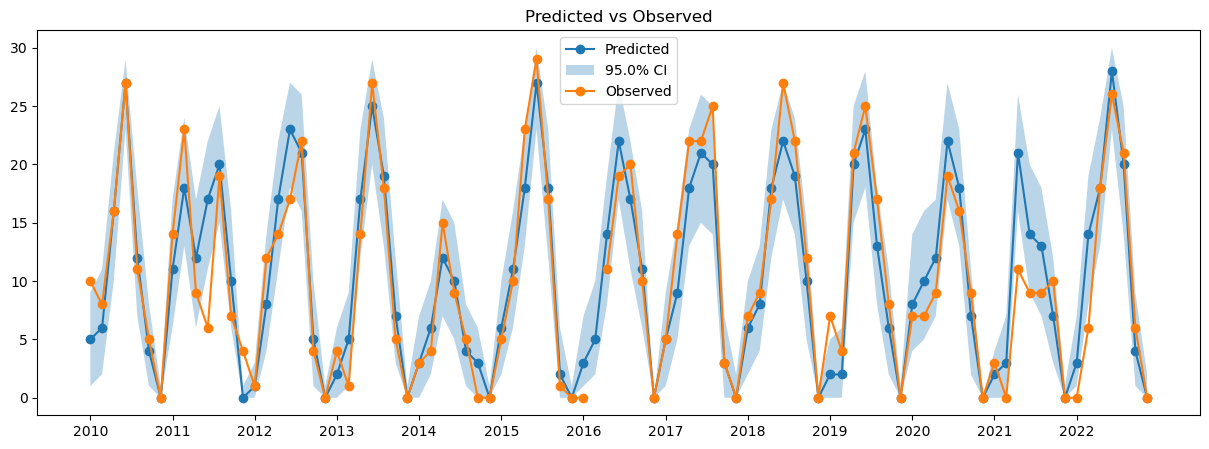

In [42]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2023))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [43]:
Models_df.loc['probit var', :] = [waic, loo, mse, mae, mad, percentage_inside, mse_test, mae_test, mad_test, percentage_inside_CI_test]
print(Models_df)

                   WAIC          LOO        MSE       MAE  MAD inside CI  \
logit      -6634.094016  -6634.49357  10.416667  2.303385  2.0  0.877865   
probit     -6669.207368 -6669.575221  10.588411  2.330729  2.0  0.874479   
logit var  -6633.335465 -6633.629074  10.448438  2.303646  2.0  0.875781   
probit var -6669.069765 -6669.449207  10.581706  2.325391  2.0  0.871875   

             MSE test  MAE test MAD test inside CI test  
logit       11.826389  2.444444      2.0       0.857639  
probit      12.041667  2.470486      2.0       0.854167  
logit var   11.914062  2.453993      2.0       0.855903  
probit var  12.057726   2.46875      2.0       0.847222  
